# **PyTorch Computer Vision**

## 0. Computer Vision libraries in Python 
* `torchvision` : base domain library for PyTorch CV 
* `torchvision.datasets` : get datasets and data loading functions for CV 
* `torchvision.models` : get pretrained CV models we can leverage for new problems 
* `torchvision.transform` : functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` : base dataset class for PyTorch 
* `torch.utils.data.DataLoader` : creates a python iterable over a dataset 

In [1]:
import torch 
from torch import nn 

import torchvision 
from torchvision import datasets 
from torchvision import transforms 
from torchvision.transforms import ToTensor 

import matplotlib.pyplot as plt 

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


## 1. Getting a dataset : Fashion MNIST  

In [2]:
# setup training data 
from torchvision import datasets 
train_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=True,  # do we want the training dataset?
    download=True, # do we want to download it?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data
    target_transform=None # how do we want to transform the label 
)

test_data = datasets.FashionMNIST(
    root="data", 
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.48MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.3MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.30MB/s]


In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx 
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
print(f"Image shape: {image.shape} -> [color_cannels, height, width]")
print(f"image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_cannels, height, width]
image label: Ankle boot


### 1.2 Visualizing data

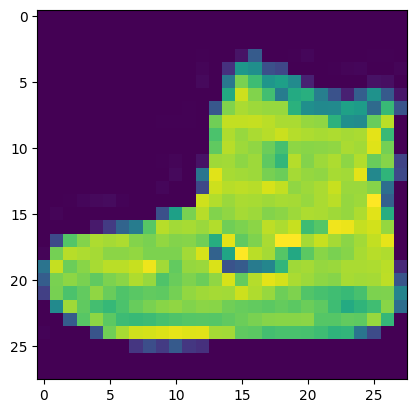

In [8]:
import matplotlib.pyplot as plt 

image, label = train_data[0]
plt.imshow(image.squeeze()) # we need squeeze to remove the color channel dimension

(-0.5, 27.5, 27.5, -0.5)

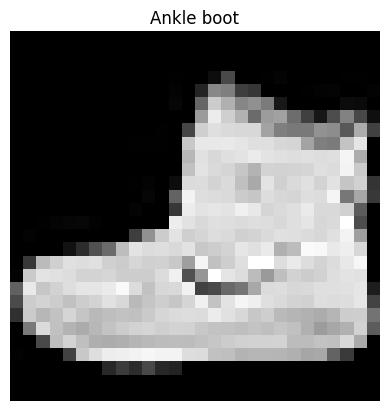

In [9]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

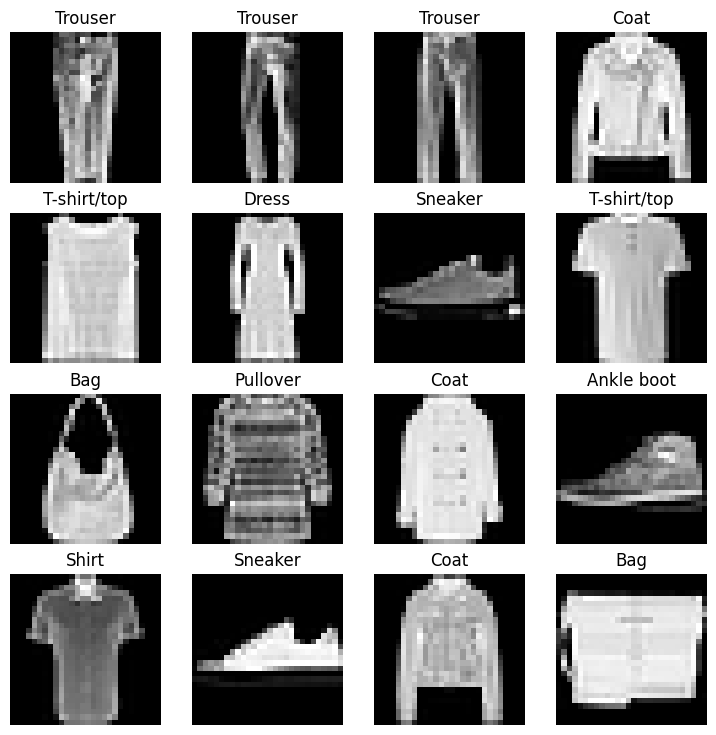

In [10]:
# plot more images 
# torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4,4 
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    # print(random_idx)
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [11]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

* Right now data is in the form of PyTorch Datasets
* DataLoader turns the dataset into a Python iterable
* more specifically, we want to turn our data into batches (or mini batches)
  1. it is more computationally efficient, as in the computing hardware may not be able to look (store in memory) at 6000 images in one hit. So we break it down to 32 images at a time (batch size = 32)
    2. it gives our NN more chances to update its ggradients per epoch (every 32 images)

In [12]:
from torch.utils.data import DataLoader 

# setup the batch size hyperparameter 
BATCH_SIZE = 32 

# turn dataset into iterables (batches)
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78caabd39850>,
 <torch.utils.data.dataloader.DataLoader at 0x78caabdf6e50>)

In [13]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)},batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)}, batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78caabd39850>, <torch.utils.data.dataloader.DataLoader object at 0x78caabdf6e50>)
Length of train_dataloader: 1875,batches of 32...
Length of test_dataloader: 313, batches of 32


In [14]:
10000/32, 32*312.5

(312.5, 10000.0)

In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader)) # iter turns train_dataloader into an iterable and next gets us the next batch
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 3, label size: torch.Size([])


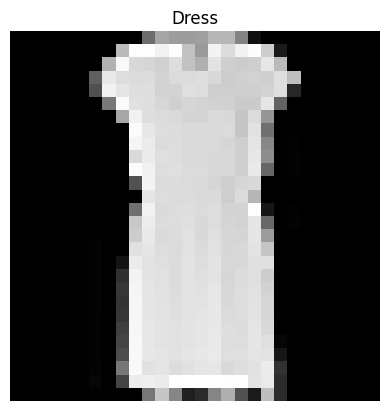

In [16]:
# show a sample 
torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: baseline model 

In [17]:
# create a flatten layer 
flatten_model = nn.Flatten()

# get a single sample 
x = train_features_batch[0]
x.shape

torch.Size([1, 28, 28])

In [18]:
# flatten the sample 
output = flatten_model(x)
print(f"Shape before flattening: {x.shape} -> [C, H, W]")
print(f"Shape after flattening: {output.shape} -> [C, H*W]")

Shape before flattening: torch.Size([1, 28, 28]) -> [C, H, W]
Shape after flattening: torch.Size([1, 784]) -> [C, H*W]


In [19]:
from torch import nn 
class FashionMNISTModelV0(nn.Module):
    def __init__(
        self, 
        input_shape: int, 
        hidden_units: int,
        output_shape: int
    ) :
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = input_shape,
                out_features = hidden_units
            ),
            nn.Linear(
                in_features = hidden_units,
                out_features = output_shape
            )
        )

    def forward(self, x):
        return self.layer_stack(x)

In [20]:
torch.manual_seed(42)

# setup model with input parameters 
model_0 = FashionMNISTModelV0(
    input_shape = 28*28, # 784
    hidden_units = 10, 
    output_shape= len(class_names) # one for each class
)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [21]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [22]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics 
* Loss function : since we're working with multi-class data -> `nn.CrossEntropyLoss()`
* Optimizer : stochastic gradient descent -> `torch.optim.SGD()`
* Evaluation metric : since we are working on a classification problem, let's use accuracy 

In [23]:
import requests 
from pathlib import Path 

if Path("helper_functions.py").is_file() :
    print("helper_functions.py already exists, skipping download")
else : 
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/af6548e52663c8395fe2777bd0fbfd6ac85fd6f8/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [24]:
!ls

data  helper_functions.py  __notebook__.ipynb


In [25]:
from helper_functions import accuracy_fn 

# setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)